# 6-1. Multi-class Classification w/ Custom ResNet model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# 런타임 유형 변경 - T4 GPU
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.1+cu121  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100%|██████████| 170498071/170498071 [00:03<00:00, 48490615.95it/s]


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [5]:
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size(), 'type:', X_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


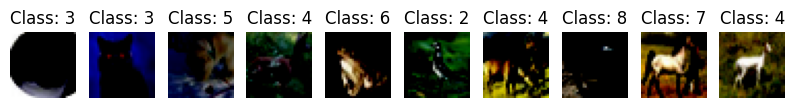

In [6]:
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1,10, i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
  plt.title('Class: ' + str(y_train[i].item()))

In [7]:
## Question 1
## Building custom ResNet model

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()   # shortcut을 빈 nn.Sequential로 초기화
        if stride != 1 or in_planes != planes:   # 입력과 출력의 차원이 다르거나, stride 가 1이 아닌 경우에 입출력 텐서를 일치시키기 위한 부분
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                #  shortcut을 통해서 conv 레이어를 건너뛰어서 출력에 직접 더하는 과정인데, 그 과정이 실행되기 위해서는 차원이 같아야하고
                #  그것을 가능하게 하기 위해서 kernel 사이즈가 1인 conv 레이어를 거치게 됩니다
                nn.BatchNorm2d(planes))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

    # BasicBlock의 구조는 (conv1, bn1, relu), (conv2, bn2), shortcut을 더하고 나서 relu를 취한다.
    #                 in_planes --> planes --> planes --> + shortcut(planes) --> relu

class ResNet(nn.Module):
    def __init__(self, num_classes = 10): # class의 개수는 10개
        super(ResNet, self).__init__()
        self.in_planes = 16 # 입력 차원은 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1) # 16을 받아서 16으로 뱉는데 블록의 개수는 2개이고 첫 블록에서 차원을 줄이지 않는다.
        self.layer2 = self._make_layer(32, 2, stride = 2) # 16를 받아서 32로 뱉는데 블록의 개수는 2개이고 첫 블록에서만 차원을 줄인다.
        self.layer3 = self._make_layer(64, 2, stride = 2) # 32를 받아서 64로 뱉는데 블록의 개수는 2개이고 첫 블록에서만 차원을 줄인다.
        self.linear = nn.Linear(64, num_classes) # 64개 --> num_classes 인 fc

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks  - 1) # num_blocks 만큼 BasicBlock을 생성
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            # 정의된 in_planes와 입력받은 planes, stride에 따라서 BasicBlock을 만든다.
            self.in_planes = planes
            # 다음 블록을 실행하기에 앞서 차원을 맞추어주기 위한 코드
        return nn.Sequential(*layers) # BasicBlock 리스트를 풀어서 Sequential 컨테이너를 결과로 뱉는다.

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8) # average pooling으로 공간적인 차원을 줄이고
        out = out.view(out.size(0), -1) # 그러한 텐서를 flatten한다.
        out = self.linear(out) # 그 flatten된 텐서를 fc에 입력해서 결과를 출력
        return out

    # ResNet의 구조는 (conv1, bn1, relu), layer1(BasicBlock, BasicBlock), layer2(BasicBlock, BasicBlock), layer3(BasicBlock, BasicBlock), fc
    # dim :        3 --> 16 -----------> 16 ----------> 16 ---------> 16 ------------> 32 --------> 32 ---------------> 64 -------> 64 --> num_classes

In [8]:
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [9]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    # image, label, output 모두 텐서의 형태를 가진다.
    loss = criterion(output, label)
    # criterion 메서드는 텐서 연산을 통해서 출력값을 계산하기 때문에 출력값도 텐서의 형태를 가진다.
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
          epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item() # 그래서 이 부분에서 loss tensor를 스칼라만 뽑아서 출력하거나 계산에 활용한다.
      ))

In [10]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [11]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.436805
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.737673
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.317329
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.476482
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.085093
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 0.867346
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.438697
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 0.770024

[EPOCH: 1], 	Test Loss: 1.0191, 	Test Accuracy: 63.08 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.032043
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.283500
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.312979
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.171597
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.718242
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.990612
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.797236
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.880718

[EPOCH: 2], 	Test Loss: 0.9182, 	Test Accuracy: 67.88 % 

# 6-2. Multi-class Classification w/ pre-trained ResNet model

In [12]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [13]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print("Using PyTorch version:", torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.1+cu121  Device: cuda


In [14]:
BATCH_SIZE = 32
EPOCHS = 10

In [15]:
train_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                 ]))
test_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                ]))
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [16]:
for (X_train, y_train) in train_loader:
  print('X_train:',X_train.size(), 'type:', X_train.type())
  print('y_train:',y_train.size(), 'type:',y_train.type())
  break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


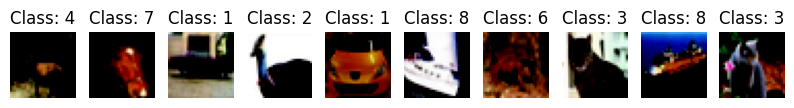

In [17]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [18]:
import torchvision.models as models
model = models.resnet34(pretrained = True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 153MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
## Important : There are 2 ways to use pre-trained models

# (1) NOT updating the weights of the pre-trained models, and use the model as it is
for parameter in model.parameters():
  parameter.requires_grad = False # We previously learned the requires_grad means utilizing backpropagation
# (2) Updating the weights of the pre-trained models
# for parameter in model.parameters():
#   parameter.requires_grad = True

# We usually use method #1 when using pre-trained models, but it's not the 100% perfect answer -- sometimes method #2 works better
# The optimal solution may vary according to the dataset or other techniques such as learning rate, optimizer, and so on

num_ftrs = model.fc.in_features # To mitigate such CIFAR"10" issue, we should add one more layer having final 10 output nodes
model.fc = nn.Linear(num_ftrs, 10) # Add such layer!

model = model.cuda()

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
          epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()
      ))

In [22]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      criterion = nn.CrossEntropyLoss()
      test_loss = criterion(output, label)
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [23]:
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
      epoch, test_loss, test_accuracy)
  )

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.564621
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.176837
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 2.120974
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.920814
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.990113
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.770321
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.888514
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.724580

[EPOCH: 1], 	Test Loss: 0.0042, 	Test Accuracy: 44.91 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.985405
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.317217
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.784226
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.352401
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.439017
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.655306
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 2.216262
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.765725

[EPOCH: 2], 	Test Loss: 0.0051, 	Test Accuracy: 47.30 % 

Question 1. Compare & Contrast the test result (accuracy) of requires_grad = False & True.

In [24]:
import torchvision.models as models
model = models.resnet34(pretrained = True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
## Important : There are 2 ways to use pre-trained models

# (1) NOT updating the weights of the pre-trained models, and use the model as it is
for parameter in model.parameters():
  parameter.requires_grad = True # We previously learned the requires_grad means utilizing backpropagation
# (2) Updating the weights of the pre-trained models
# for parameter in model.parameters():
#   parameter.requires_grad = True

# We usually use method #1 when using pre-trained models, but it's not the 100% perfect answer -- sometimes method #2 works better
# The optimal solution may vary according to the dataset or other techniques such as learning rate, optimizer, and so on

num_ftrs = model.fc.in_features # To mitigate such CIFAR"10" issue, we should add one more layer having final 10 output nodes
model.fc = nn.Linear(num_ftrs, 10) # Add such layer!

model = model.cuda()

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
          epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()
      ))

In [28]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      criterion = nn.CrossEntropyLoss()
      test_loss = criterion(output, label)
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [29]:
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
      epoch, test_loss, test_accuracy)
  )

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.548713
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.372294
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.230508
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 0.856074
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 0.991771
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 0.853036
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.093616
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 0.853883

[EPOCH: 1], 	Test Loss: 0.0040, 	Test Accuracy: 70.89 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 0.855264
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.861810
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.766817
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.127607
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.955747
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.628679
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.579820
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.902778

[EPOCH: 2], 	Test Loss: 0.0021, 	Test Accuracy: 72.56 % 

Question 2. Change the model ResNet34 to ResNet50 and run the entire code. Compare & Contrast the results of those two models.

In [60]:
import torchvision.models as models
model = models.resnet50(pretrained = True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [61]:
## Important : There are 2 ways to use pre-trained models

# (1) NOT updating the weights of the pre-trained models, and use the model as it is
for parameter in model.parameters():
  parameter.requires_grad = False # We previously learned the requires_grad means utilizing backpropagation
# (2) Updating the weights of the pre-trained models
# for parameter in model.parameters():
#   parameter.requires_grad = True

# We usually use method #1 when using pre-trained models, but it's not the 100% perfect answer -- sometimes method #2 works better
# The optimal solution may vary according to the dataset or other techniques such as learning rate, optimizer, and so on

num_ftrs = model.fc.in_features # To mitigate such CIFAR"10" issue, we should add one more layer having final 10 output nodes
model.fc = nn.Linear(num_ftrs, 10) # Add such layer!

model = model.cuda()

In [62]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [63]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
          epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()
      ))

In [64]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      criterion = nn.CrossEntropyLoss()
      test_loss = criterion(output, label)
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [65]:
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
      epoch, test_loss, test_accuracy)
  )

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.362101
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.769079
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.691067
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 2.017988
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.502724
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.597196
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.549339
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.415088

[EPOCH: 1], 	Test Loss: 0.0046, 	Test Accuracy: 48.42 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.447404
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.442663
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.543764
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 2.046005
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.596670
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.857313
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.684798
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.241540

[EPOCH: 2], 	Test Loss: 0.0036, 	Test Accuracy: 49.12 % 

Question 3. Change the model ResNet34 to Inceptionv3 or v4 and run the entire code. Compare & Contrast the results of those two models.

In [87]:
import keras
from keras.datasets import cifar10
from keras.utils import to_categorical

# Load the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [91]:
num_classes = 10
y_train=to_categorical(y_train,num_classes)
y_test=to_categorical(y_test,num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

print('Original training data shape: {}'.format(x_train.shape))
print('Training label shape: {}'.format(y_train.shape))

Original training data shape: (50000, 32, 32, 3)
Training label shape: (50000, 10)


In [92]:
from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(include_top=True, weights='imagenet', classes=1000)

96112376/96112376 [==============================] - 1s 0us/step


In [93]:
from keras.models import Model
from keras.layers import Lambda, Input
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(include_top=False, input_shape=(75, 75, 3), weights='imagenet')

# Resize Input images to 75x75
newInput = Input(batch_shape=(None, 32, 32, 3))
resizedImg = Lambda(lambda image: tf.compat.v1.image.resize_images(image, (75, 75)))(newInput)
newOutputs = model(resizedImg)
model = Model(newInput, newOutputs)

# Freeze all the layers
for layer in model.layers[:]:
    layer.trainable = False

# Add Dense layer to classify on CIFAR10
output = model.output
output = GlobalAveragePooling2D()(output)
output = Dense(units=10, activation='softmax')(output)
model = Model(model.input, output)

model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda_3 (Lambda)           (None, 75, 75, 3)         0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 21823274 (83.25 MB)
Trainable params: 20490 (8

In [95]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(x_train, y_train, epochs=3, batch_size=32)

Epoch 1/3
1563/1563 [==============================] - 31s 16ms/step - loss: 1.2970 - categorical_accuracy: 0.5591
Epoch 2/3
1563/1563 [==============================] - 27s 18ms/step - loss: 1.1097 - categorical_accuracy: 0.6200
Epoch 3/3
1563/1563 [==============================] - 24s 15ms/step - loss: 1.0679 - categorical_accuracy: 0.6327


In [96]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 9s 15ms/step - loss: 1.1838 - categorical_accuracy: 0.6065
Test loss: 1.1838047504425049
Test accuracy: 0.6065000295639038


ref) https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/04_Common_CNN_architectures.ipynb#scrollTo=dRB4GcuJxbp_

In [ ]:
# Inceptionv3, Inceptionv4 input shape가 cifar10 와 다르므로 모델을 수정해주어야 하는데 까다로워 keras 모델로 실행했음.